## <center><strong><font size ='8'>- Export vs unemployment -</font></strong></center>

## 1 <span style='color:#164cf0'>|</span> Import libraries

<p><font size = '4'>before running the code make sure to have all the libraries required installed (check the file REQUIREMENTS.txt)</font></p>
<p><font size = '4'>The libraries listed are necessary to run the code properly on visual studio code, the list includes sone libraries used for the graphic rendering of the notebook in the IDE so if you are running the code in colab you don't need to install them.</font></p>

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ipywidgets as widgets
import statsmodels.api as sm
import statistics
from scipy.stats import t

from sklearn import preprocessing

#custom scripts
import manage_data
import plot_data

## 2 <span style='color:#164cf0'>|</span> import data

<font size = '4'>2.1 <span style='color:#164cf0'>|</span> import unemployment rates data</font>

In [2]:
un_rates_df = pd.read_csv('data/unemployment_rate.csv')
#delete useless columns
un_rates_df.drop(['Series Name','Series Code','1990 [YR1990]'], inplace= True, axis= 1)
#rename columns
un_rates_df.columns = ['country', 'country code'] + [i for i in range(1991,2021)]

In [3]:
#modify dataset to make it more accessible
un_rates_df = pd.melt(un_rates_df, id_vars=['country', 'country code'],var_name="year", value_name="value")
un_rates_df = un_rates_df.sort_values(['country', 'year'])

In [4]:
#drop rows with no value
un_rates_df.drop(un_rates_df[un_rates_df['value'] == '..'].index, axis = 0, inplace = True)
un_rates_df = un_rates_df.loc[un_rates_df['year'] >= 2000]

In [5]:
un_rates_df.head()

,country,country code,year,value
1953,Afghanistan,AFG,2000,10.8059997558594
2170,Afghanistan,AFG,2001,10.8090000152588
2387,Afghanistan,AFG,2002,11.2569999694824
2604,Afghanistan,AFG,2003,11.1409997940063
2821,Afghanistan,AFG,2004,10.9879999160767


<font size = '4'>2.2 <span style='color:#164cf0'>|</span> import services export data</font>

In [6]:
#download all the json files containg the information about exports
manage_data.download_jsons(destination='export_data', start_date = 2000, end_date = 2020, type = 2)

In [7]:
#turn the json files into a single dataframe
df_exports, cat_map = manage_data.create_df('export_data')
#drop EU
df_exports.drop(df_exports.loc[df_exports['country'] == 'EU'].index, axis=0, inplace=True)

processing year: 2020: 100%|██████████| 21/21 [00:05<00:00,  3.89it/s]


In [8]:
df_exports.head()

,country,year,200,205,236,245,249,253,260,262,...,950,960,961,962,970,983,999,851,852,850
0,Afghanistan,2008,0,123489461,21275821,0,662126945,670193,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Afghanistan,2009,0,147976244,39038728,0,701645334,1878536,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Afghanistan,2010,0,215035884,55179237,0,1056567947,3157760,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Afghanistan,2011,0,255550457,71090307,0,1161146581,42565151,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Afghanistan,2012,0,174345893,103858542,62139240,550983038,26275322,0,3700882,...,0,0,0,0,0,0,0,0,0,0


the export data are divided into different categories, as you can see I decided to take only the parent classes. I've decided to preceed this way for 2 reasons:
- the dataset misses a lot of data so a lot of categories would results empty for the majority of countries
- as we will see the export data are higly correlated with each others so we don't need all the single categories

## 3 <span style='color:#164cf0'>|</span> Clean and merge the datasets

In [9]:
len_df = len(df_exports)
for i in df_exports.iloc[:,2:]:
    values = df_exports[i].value_counts()
    print(f'category {i} has: {math.trunc((values[0]/len_df)*100)}% of zeros')

category 200 has: 99% of zeros
category 205 has: 26% of zeros
category 236 has: 21% of zeros
category 245 has: 38% of zeros
category 249 has: 65% of zeros
category 253 has: 47% of zeros
category 260 has: 100% of zeros
category 262 has: 59% of zeros
category 266 has: 75% of zeros
category 268 has: 33% of zeros
category 287 has: 52% of zeros
category 291 has: 58% of zeros
category 887 has: 100% of zeros
category 888 has: 100% of zeros
category 894 has: 100% of zeros
category 900 has: 100% of zeros
category 950 has: 100% of zeros
category 960 has: 100% of zeros
category 961 has: 100% of zeros
category 962 has: 100% of zeros
category 970 has: 97% of zeros
category 983 has: 100% of zeros
category 999 has: 95% of zeros
category 851 has: 100% of zeros
category 852 has: 100% of zeros
category 850 has: 100% of zeros


beacause of the lack of data i decided to pick the top 5 categories in terms of data avilable, these categories are:
- 205 (Transportation)
- 236 (Travel)
- 245 (Communications services)
- 253 (Insurance services)
- 268 (Other business services)

In [10]:
# drop the columns with too much missing data
keep_columns = ['country', 'year', '205', '236', '245', '253', '268']
df_exports.drop([i for i in df_exports if i not in keep_columns], axis=1, inplace=True)

In [11]:
#count the number of non-common countries in the datasets
countries_un = un_rates_df['country'].unique()
countries_ex = df_exports['country'].unique()
len(list(set(countries_ex)-set(countries_un)))

46

apparently there are 20 countries that miss from the un_rates dataframe, but this is due to the way countries are named in the datasets. Foe exemple one dataset write "Republic" and the other just write "Rep" or sometimes the order of the names is inverted. To solve this problem I created an hash map that changes the names of the countries to meke them compatible.

In [12]:
with open('countries_names_map.json', 'r') as f:
    countries_map = json.load(f)['names_map']

un_rates_df['country'].replace(countries_map, inplace = True)

In [13]:
countries_un = un_rates_df['country'].unique()
countries_ex = df_exports['country'].unique()
list(set(countries_ex)-set(countries_un))

['Saint Helena',
 'Bermuda',
 'Curaçao',
 'Greenland',
 'State of Palestine',
 'Anguilla',
 'Cayman Isds',
 'Grenada',
 'Seychelles',
 "Côte d'Ivoire",
 'Montserrat',
 'Faeroe Isds',
 'Dominica',
 'Marshall Isds',
 'FS Micronesia',
 'Saint Kitts and Nevis',
 'Antigua and Barbuda',
 'Neth. Antilles',
 'Kiribati',
 'Asia n.i.e.']

unfortunatly the unemployment rates dataframe doesn't contain 20 of the 188 countrie contained in the export datafraem. Because all these countries are just little islands we will delete them

In [14]:
not_common = list(set(countries_un)-set(countries_ex)) + list(set(countries_ex) - set(countries_un))
df_exports.drop(df_exports.loc[df_exports['country'].isin(not_common)].index, axis= 0, inplace=True )
un_rates_df.drop(un_rates_df.loc[un_rates_df['country'].isin(not_common)].index, axis= 0, inplace=True)

now the dataframes contains data about the same countries and we can merge them

In [15]:
total_df = df_exports.merge(un_rates_df, on=['country', 'year'])
total_df['value'] = total_df['value'].map(lambda x: round(float(x),4))

In [16]:
total_df.replace(0, np.NaN, inplace=True)
total_df

,country,year,205,236,245,253,268,country code,value
0,Afghanistan,2008,123489461.0,21275821.0,NaN,670193.0,6.035989e+07,AFG,11.093
1,Afghanistan,2009,147976244.0,39038728.0,NaN,1878536.0,1.873522e+08,AFG,11.311
2,Afghanistan,2010,215035884.0,55179237.0,NaN,3157760.0,5.296138e+08,AFG,11.352
3,Afghanistan,2011,255550457.0,71090307.0,NaN,42565151.0,1.255528e+09,AFG,11.054
4,Afghanistan,2012,174345893.0,103858542.0,62139240.0,26275322.0,3.062497e+08,AFG,11.341
...,...,...,...,...,...,...,...,...,...
2374,Zambia,2017,NaN,652552188.0,37019590.0,75443304.0,5.745252e+06,ZMB,11.630
2375,Zimbabwe,2012,85638227.0,160787751.0,2307714.0,NaN,6.246386e+07,ZWE,5.153
2376,Zimbabwe,2013,85238089.0,169869988.0,2413870.0,NaN,6.536188e+07,ZWE,4.982
2377,Zimbabwe,2014,87586505.0,172308007.0,2524909.0,NaN,6.839437e+07,ZWE,4.770


## 4 <span style='color:#164cf0'>|</span> Visualize data and their correlations

the following chunk of code let you plot the data available for the country selected from the drop-down menu along with their correlation matrix. If the option normalized is set to True all the data will be normalized before they are plotted, this is very usefull if some categories have a different size-scale.

In [18]:
#the following function creates an intercative plot, where you can select the country from the drop-down menu.
#the function will plot the country unemplyment rate along with exports data and their correlation.

widgets.interact(plot_data.plot_series, country = [i for i in total_df['country'].unique()], 
                normalized =False, df = widgets.fixed(total_df), cat_map= widgets.fixed(cat_map))

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'Angola', …

<function plot_data.plot_series(country, normalized, df, cat_map)>

In [19]:
#correlation matrixes
correlations_plain = {}
data_columns = ['value', '205', '236', '245', '253', '268']

for i in total_df['country'].unique():
    correlations_plain[i] = total_df.loc[total_df['country'] == i][data_columns].corr().iloc[0][1:]


In [20]:
corr_list_plain = []

for i in correlations_plain.items():
    corr_list_plain.append(i[1].values)
    
corr_list_plain = np.ravel(corr_list_plain)[np.logical_not(np.isnan(np.ravel(corr_list_plain)))]
#remove all the values equal to 1.0 or -1.0 as they are the results of missing data
corr_list_plain = corr_list_plain[abs(corr_list_plain) != 1.0]

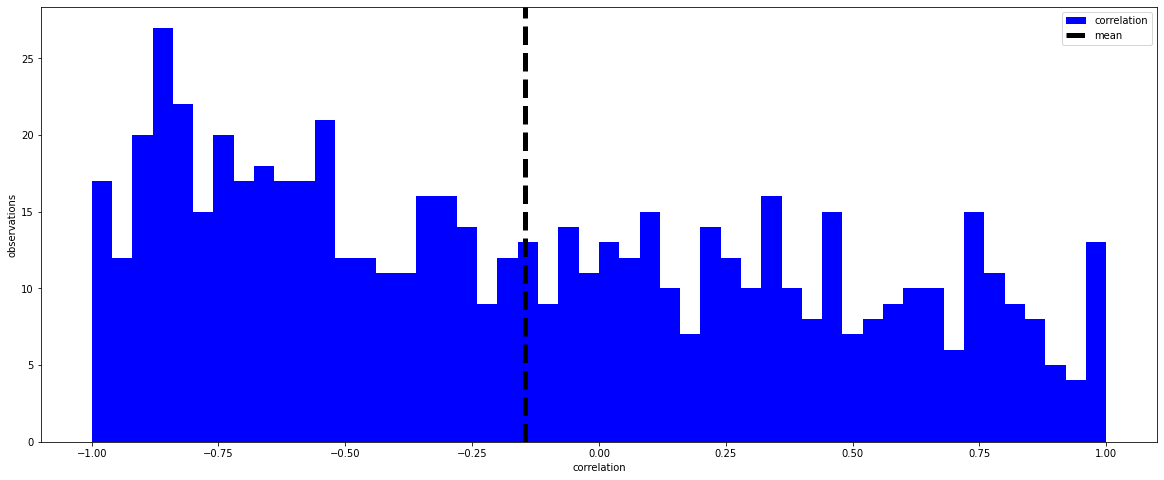

In [21]:
plt.figure(figsize=(20,8), facecolor='White')
plt.hist(corr_list_plain, bins=50, color = 'blue', label = 'correlation')
plt.axvline(x= statistics.mean(corr_list_plain), color = 'black', lw = 5, label = 'mean', ls = '--')
plt.xlabel('correlation')
plt.ylabel('observations')
plt.legend()

Above we can see the distribution of the correlation values, the average resusts to be slightly negative as the left tail of the distribution is heavier then the right one.

<font size='4'> 4.1 <span style='color:#164cf0'>|</span> Inference on the correlations distribution</font>

<p>To be sure that the negative mean observed in the sample is significantly less then 0 i'll make inference on the correlation distribution </p>
<p>The process will be an hypothesis  on the mean of normal distributed population with unknown variance, the hypothesis system is: </p> 

$$\left\{\begin{matrix}
H_{0}:\mu = 0\\ 
H_{1}:\mu < 0
\end{matrix}\right.$$

The test statisctics is:
$$T = \frac{\bar{X} - \mu_{0}}{S_{n}/\sqrt{n}}$$

this test statistics under $H_{0}$ is distributed as t student with n-1 degree of freedom
$$T\mid H_{0} \sim t_{n-1}$$

In [22]:
alpha = 0.05
n = len(corr_list_plain)
df = n-1

#calculate the population mean
X_mean = statistics.mean(corr_list_plain)
#calculate the sample variance
X_var = statistics.variance(corr_list_plain)
t_alpha = t.ppf(alpha,df = df)

#calulate the rejection area and p-value
h_alpha = t_alpha * (math.sqrt(X_var)/math.sqrt(n))
print(f'rejection theshold: {h_alpha}')
print(f'sample mean: {X_mean}')

stat_test = (X_mean/math.sqrt(X_var/n))
pvalue = t.pdf(stat_test, df = df)
print(f'p-value: {pvalue}')

rejection theshold: -0.03730529567539428
sample mean: -0.14499035137392213
p-value: 9.13499508222385e-10


as we can see the mean of all the correaltions is less then the rejection area theshold and the p-value is far below 5%, so that means the average is significally less then 0 with a confidence level of 5%.

<font size='4'> 4.1.2 <span style='color:#164cf0'>|</span> plot the theoretical distribution</font>

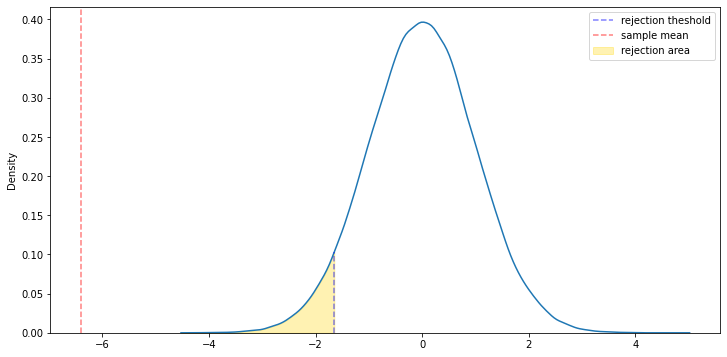

In [23]:
#create some random sample to plot the distrbution
x_dist = t.rvs(df = df, size = 100000)

fig, ax = plt.subplots(figsize=(12, 6), facecolor = 'white')

sns.kdeplot(x_dist, ax=ax)

x = ax.lines[-1].get_xdata()
y = ax.lines[-1].get_ydata()

#add all the vertical line and shadows
ax.vlines(t_alpha, 0, np.interp(t_alpha, x, y), color = 'blue', linestyle='--', alpha=0.5, label = 'rejection theshold')
ax.axvline(stat_test, linestyle='--', color='red', alpha=0.5, label = 'sample mean')
ax.fill_between(x, 0, y, where=x < t_alpha, color='gold', alpha=0.3, label = 'rejection area')
ax.legend()

<font size='5'> 4.2 <span style='color:#164cf0'>|</span> Observation</font>

As we can see for some countries exports data are positively correlated with the unemploynment rate and for other is not. That sounds strange, beacuse a rise in unemploynment rates should indicate a period of crisis with a consequent drop in exports. To investigate this relation I came up with two different theories

## 5 <span style='color:#164cf0'>|</span> study exports and unemploynment correlation

I came up with two possible explanations for the positive correlation between unemployment and export some countries presents

<font size='4'> 5.1 <span style='color:#164cf0'>|</span> 1° - It's due to the development level of the country</font>

the first idea is that the correlation between exports and unemplynment depends by the level of development of the country. Maybe a developed country with a strong internal economy has exports revenues that are less sensitive to periods of crisis and rise in unemploynment rates, while a less developed country could have a more sensible exports revenues. 

In [24]:
corr_df = total_df.copy()

for country in correlations_plain:
    for cat in correlations_plain[country].keys():
        
        corr_df.loc[corr_df.loc[corr_df['country'] == country].index,cat] = correlations_plain[country][cat]

As index for the country development I took the Human development Index

In [25]:
hdi_df = pd.read_csv('data\HDI.csv')
corr_df = corr_df.merge(hdi_df, on= ['country'])

for the plot we take only the countries with more than 10 observations

In [26]:
country_samples = corr_df['country'].value_counts()
greater_10 = []

for i in country_samples.keys():
    if country_samples[i] > 10:
        greater_10.append(i)

In [27]:
def plot_hdi_corr(category):
        
    plt.figure(figsize=(20,8))
    plt.scatter(corr_df.loc[(corr_df['year'] == 2019) & (corr_df['country'].isin(greater_10))]['HDI'], corr_df.loc[(corr_df['year'] == 2019) & (corr_df['country'].isin(greater_10))][category])
    plt.xlabel('HDI')
    plt.ylabel('unemployment - export correlation')

widgets.interact(plot_hdi_corr, category = data_columns[1:])

interactive(children=(Dropdown(description='category', options=('205', '236', '245', '253', '268'), value='205…

<function __main__.plot_hdi_corr(category)>

It seems like there's no correlation beetwen the unemplaynment - exports correlation and the country development index

<font size='4'> 5.2 <span style='color:#164cf0'>|</span> 2° - the real correlation is contained in the shocks</font>

the idea is that the exports grow with time and the real correlation is contained in the shocks. To find It we will remove the trend from the export series and search for correlatiotion in the residuals, to do that we will use only the countries with at least 10 years of data, what we expect to find is reduced right tail in the correlation distribution

In [28]:
# drop rows with Nan
complete_rows_df = total_df.dropna(axis=0)
complete_rows_df_norm = complete_rows_df

X_data = ['205', '236', '245', '253', '268']
Y_data = ['value']

for country in complete_rows_df_norm['country'].unique():
    for col in X_data + Y_data:

        norm_data = preprocessing.normalize([complete_rows_df_norm.loc[complete_rows_df_norm['country'] == country][col]])[0]
        complete_rows_df_norm.loc[complete_rows_df_norm['country'] == country, col] = norm_data

In [29]:
# calculate trend and get residuals
for country in complete_rows_df_norm['country'].unique():
    for cat in X_data:
        series_len = len(complete_rows_df_norm.loc[complete_rows_df_norm['country'] == country])
        
        t_serie = sm.add_constant(range(1,series_len+1))
        
        model_ols = sm.OLS(np.array(complete_rows_df_norm.loc[complete_rows_df_norm['country'] == country][cat]),t_serie)
        trend = model_ols.fit()

        complete_rows_df_norm.loc[complete_rows_df_norm['country'] == country, cat] =trend.resid

In [30]:
widgets.interact(plot_data.plot_series, country = [i for i in complete_rows_df_norm['country'].unique()],
                normalized = widgets.fixed(False), df = widgets.fixed(complete_rows_df_norm), cat_map = widgets.fixed(cat_map))

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'Argentina…

<function plot_data.plot_series(country, normalized, df, cat_map)>

In [31]:
#correlation matrixes
correlations_res = {}
data_columns = ['value', '205', '236', '245', '253', '268']

for i in complete_rows_df_norm['country'].unique():
    correlations_res[i] = complete_rows_df_norm.loc[complete_rows_df_norm['country'] == i][data_columns].corr().iloc[0][1:]

corr_list_resid = []

for i in correlations_res.items():
    corr_list_resid.append(i[1].values)

corr_list_resid = np.ravel(corr_list_resid)[np.logical_not(np.isnan(np.ravel(corr_list_resid)))]
#remove all the values equal to 1.0 or -1.0 as they are the results of missing data
corr_list_resid = corr_list_resid[abs(corr_list_resid) != 1.0]

<Figure size 1440x576 with 0 Axes>

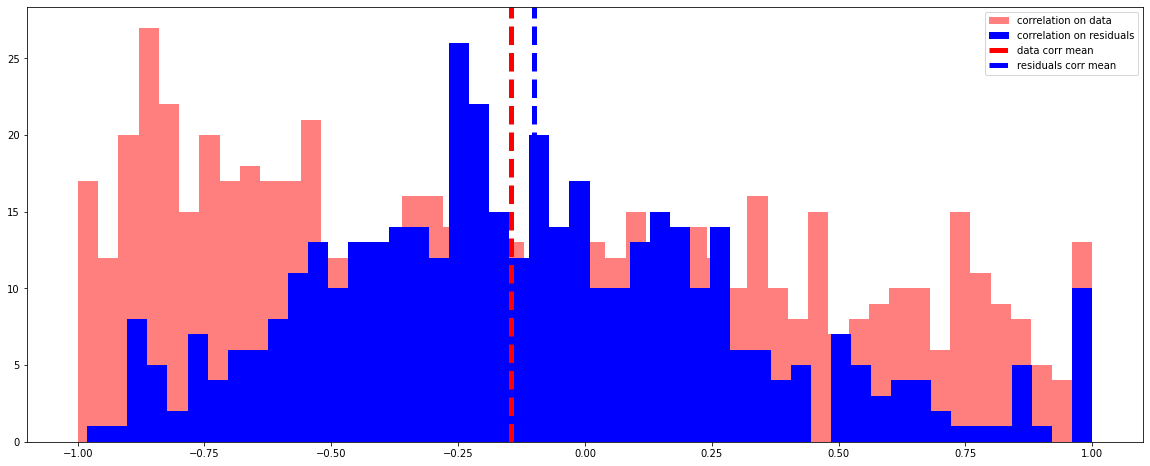

In [32]:
plt.figure(figsize=(20,8), facecolor='White')

plt.figure(figsize=(20,8), facecolor='White')
plt.hist(corr_list_plain, bins=50, alpha = 0.5, color = 'red', label='correlation on data')
plt.hist(corr_list_resid, bins=50, color = 'blue', label='correlation on residuals')

plt.axvline(x= statistics.mean(corr_list_plain), color = 'red', lw = 5, label = 'data corr mean', ls = '--')
plt.axvline(x= statistics.mean(corr_list_resid), color = 'blue', lw = 5, label = 'residuals corr mean', ls = '--')
plt.legend()

In [33]:
n_resid = len(corr_list_resid)
df_resid = n-1

#calculate the population mean
X_mean_resid = statistics.mean(corr_list_resid)
#calculate the sample variance
X_var_resid = statistics.variance(corr_list_resid)
t_alpha_resid = t.ppf(alpha,df = df_resid)

#calulate the rejection area and p-value
h_alpha_resid = t_alpha_resid * (math.sqrt(X_var_resid)/math.sqrt(n_resid))
print(f'rejection theshold: {h_alpha_resid}')
print(f'sample mean: {X_mean_resid}')

stat_test_resid = (X_mean_resid/math.sqrt(X_var_resid/n_resid))
pvalue_resid = t.pdf(stat_test_resid, df = df_resid)
print(f'p-value: {pvalue_resid}')

rejection theshold: -0.03360858419363982
sample mean: -0.10097876792014569
p-value: 2.360487368910712e-06


as we can see the correlation distribution is very different from the other one, in particualar, It presents a reduced variance and lighter tails. The mean is slightly higher then the previous distribution but still significantly less then 0.